# Spotify Hit Classification

In this notebook I will attempt to build a classifier that determines how likely a song is to become a hit. The data comes from "The Spotify Hit Predictor Dataset (1960-2019)" on Kaggle.

## Data Description

- **Track**: The Name of the track.

- **Artist**: The Name of the Artist.

- **URI**: The resource identifier for the track.

- **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **Duration_Ms**:  The duration of the track in milliseconds.

- **TimeSignature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **Chorus_Hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Target**: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.

      The author's condition of a track being 'flop' is as follows:

        - The track must not appear in the 'hit' list of that decade.
        - The track's artist must not appear in the 'hit' list of that decade.
        - The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
        - The track's genre must not have a song in the 'hit' list.
        - The track must have 'US' as one of its markets.

## Imports

In [51]:
import os
os.chdir(r"C:\Users\tom.dawson\Documents\Git Projects\SpotifyMusicData")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from optbinning import OptimalBinning
import math
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import tree, svm
from sklearn.datasets import load_iris
import graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from SpotifyFunctions import DistributionPlot, Scatter, Distribution, BinVariable, Correlation, BarPlot

from sklearn.ensemble import RandomForestClassifier

## Data Processing

To start, we iterate over each csv file in the directory and add to the main DataFrame along with a new column for identifying trends over time. We then standardise column names to have an uppercase first letter and define some new variables based on the data spec.

We then define the groups of continuous and discrete variable groups (for ease of plotting) and, finally, split the data into a randomly shuffled train and test split.

In [2]:
#Misc
Csv = ["dataset-of-60s", "dataset-of-70s", "dataset-of-80s", "dataset-of-90s", "dataset-of-00s", "dataset-of-10s"] 
Data = pd.DataFrame()

for Set in Csv:
    Temp = pd.read_csv(f"DataSets\{Set}.csv")
    Temp["decade"] = [Set.split("-")[-1].replace("s",'')]*len(Temp)

    Data = Data.append(Temp)
    
for Column in Data.columns.values:
    Data[str(Column).title()] = Data[Column]
    del Data[Column]
    
Data["LowEnergy"] = Data["Energy"].apply(lambda x: 1 if x <= 0.2 else 0)
Data["Acoustic"] = Data["Acousticness"].apply(lambda x: 1 if x >= 0.8 else 0)
Data["FourFour"] = Data["Time_Signature"].apply(lambda x: 1 if x == 4 else 0)
    
    
ContinuousVars = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
                   'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
                   'Duration_Ms', 'Chorus_Hit', 'Sections']

DiscreteVars = ["Time_Signature", "Mode", "Key", "Acoustic", "FourFour", "LowEnergy"]

# Split to train test
Data["Population"] = np.random.randint(1, 100, len(Data))
Data["Population"] = Data["Population"].apply(lambda x: "Train" if x <= 80 else "Test")

Train = Data.copy()
Test = Data.copy()
Train = Train[(Train["Population"] == "Train")]
Test = Test[(Test["Population"] == "Test")]

In [3]:
Train.columns.values

array(['Track', 'Artist', 'Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_Ms',
       'Time_Signature', 'Chorus_Hit', 'Sections', 'Target', 'Decade',
       'LowEnergy', 'Acoustic', 'FourFour', 'Population'], dtype=object)

## EDA

Key points that stand out:

- Some mixes have greater than 0 Decibels (Loudness/Amplitude), which is typically a no-go in music production.
- Most datapoints are in Major (Mode), which is typically a happier sound.

In [4]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33263 entries, 0 to 6397
Data columns (total 24 columns):
Track               33263 non-null object
Artist              33263 non-null object
Uri                 33263 non-null object
Danceability        33263 non-null float64
Energy              33263 non-null float64
Key                 33263 non-null int64
Loudness            33263 non-null float64
Mode                33263 non-null int64
Speechiness         33263 non-null float64
Acousticness        33263 non-null float64
Instrumentalness    33263 non-null float64
Liveness            33263 non-null float64
Valence             33263 non-null float64
Tempo               33263 non-null float64
Duration_Ms         33263 non-null int64
Time_Signature      33263 non-null int64
Chorus_Hit          33263 non-null float64
Sections            33263 non-null int64
Target              33263 non-null int64
Decade              33263 non-null object
LowEnergy           33263 non-null int64
Acousti

In [5]:
Train.describe()

Danceability        Energy           Key      Loudness          Mode  \
count  33263.000000  33263.000000  33263.000000  33263.000000  33263.000000   
mean       0.538076      0.578931      5.216637    -10.235603      0.693774   
std        0.177624      0.253249      3.537438      5.292711      0.460932   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.419000      0.395000      2.000000    -12.842500      0.000000   
50%        0.550000      0.601000      5.000000     -9.279000      1.000000   
75%        0.667000      0.787000      8.000000     -6.400000      1.000000   
max        0.986000      1.000000     11.000000      3.744000      1.000000   

        Speechiness  Acousticness  Instrumentalness      Liveness  \
count  33263.000000  33263.000000      33263.000000  33263.000000   
mean       0.072992      0.365375          0.154732      0.202077   
std        0.087077      0.339275          0.303812      0.173262   
min        0.000000      0.000000          0.000000      0.013600   
25%        0.033600      0.039550          0.000000      0.094200   
50%        0.043300      0.261000          0.000122      0.132000   
75%        0.069500      0.677000          0.061300      0.262000   
max        0.960000      0.996000          1.000000      0.997000   

            Valence         Tempo   Duration_Ms  Time_Signature    Chorus_Hit  \
count  33263.000000  33263.000000  3.326300e+04    33263.000000  33263.000000   
mean       0.540889    119.291083  2.351671e+05        3.891802     40.102372   
std        0.267706     29.171906  1.191259e+05        0.428580     18.969706   
min        0.000000      0.000000  1.562900e+04        0.000000      0.000000   
25%        0.328000     97.315500  1.729600e+05        4.000000     27.665365   
50%        0.557000    117.409000  2.179370e+05        4.000000     35.838160   
75%        0.766000    136.569000  2.670670e+05        4.000000     47.664190   
max        0.996000    241.423000  4.170227e+06        5.000000    433.182000   

           Sections        Target     LowEnergy      Acoustic      FourFour  
count  33263.000000  33263.000000  33263.000000  33263.000000  33263.000000  
mean      10.489763      0.497460      0.092595      0.168325      0.882452  
std        4.924047      0.500001      0.289869      0.374160      0.322077  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        8.000000      0.000000      0.000000      0.000000      1.000000  
50%       10.000000      0.000000      0.000000      0.000000      1.000000  
75%       12.000000      1.000000      0.000000      0.000000      1.000000  
max      169.000000      1.000000      1.000000      1.000000      1.000000

## Distributions

From the distribution plots, we can see many examples of the way in which our features interact with the target.

- We see that in general, hits tend to be more Danceable, this makes sense in general due to pop music typically being the type that people dance to.

- We see the same for energy - songs with more energy are more likely to be hits. Although, up to extreme levels of energy we see a drop in the volume of hits. This is possibly down to them correlating with certain genres like Metal or Heavy Dance music.

- As expected, louder mixes tend to make better hits than quieter. In the industry, producers (especially nowadays) tend to strive for louder and louder mixes.

- Very Acoustic songs tend not to make very good hits, this is possibly down to the low energy that often comes with these songs, these variables could possibly correlate with one another.

- Happier songs tend to make better hits, this is to be expected due to the positive impact happy songs can have on the listener.

- There is a clear sweet spot for duration, which definitely makes sense - listener attention span, radio conventions etc.

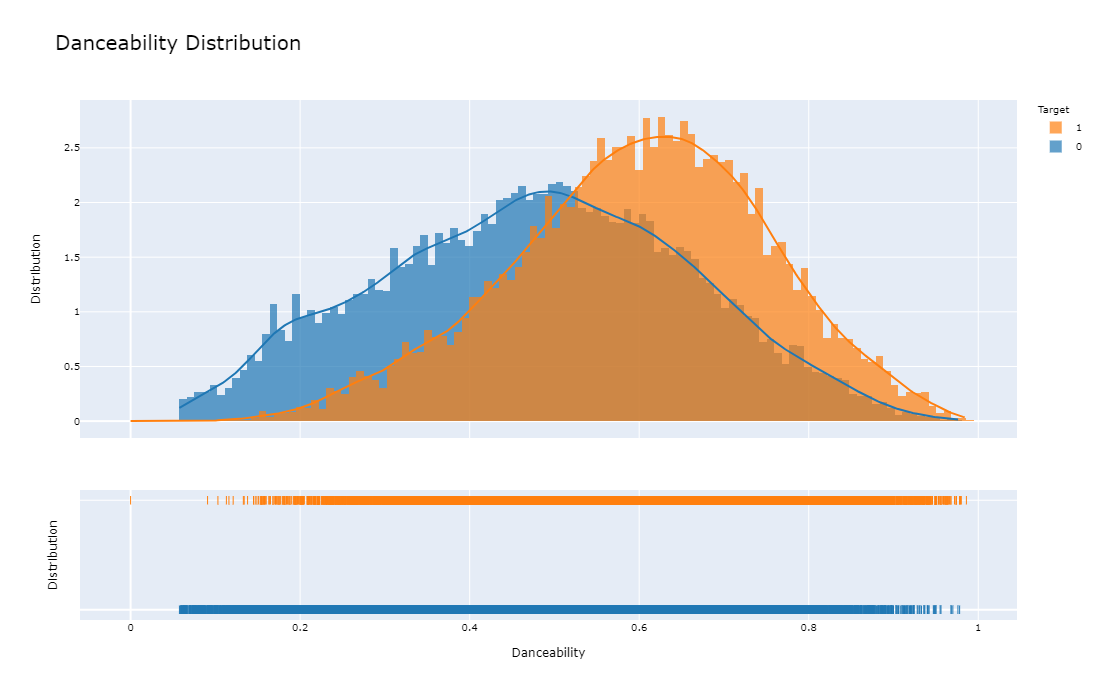

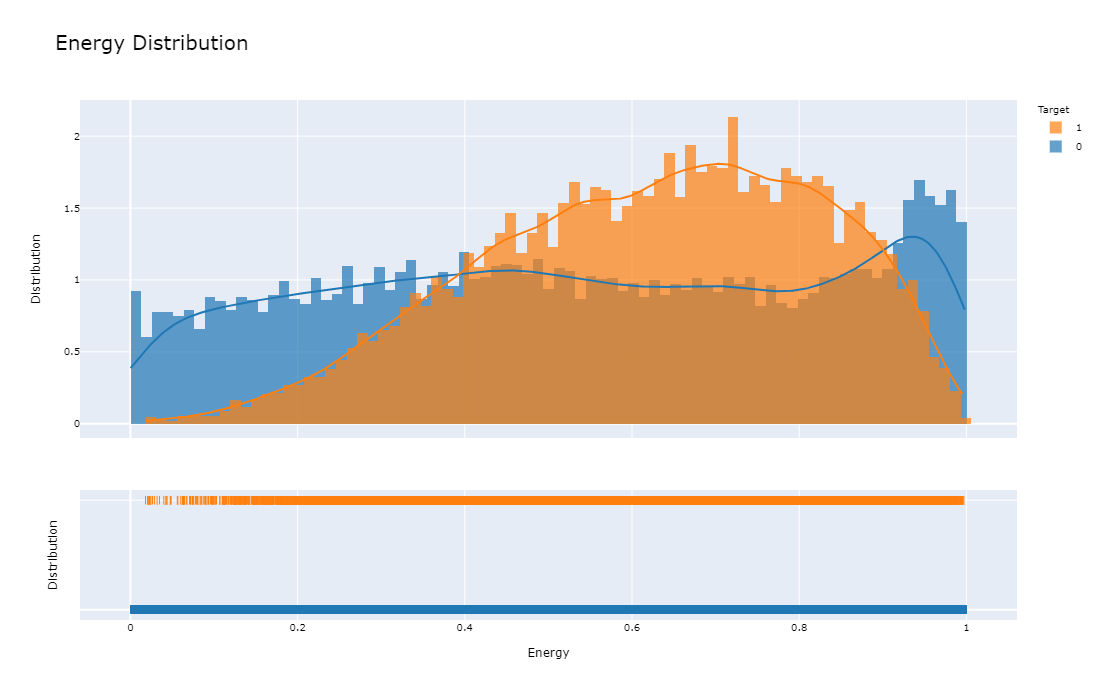

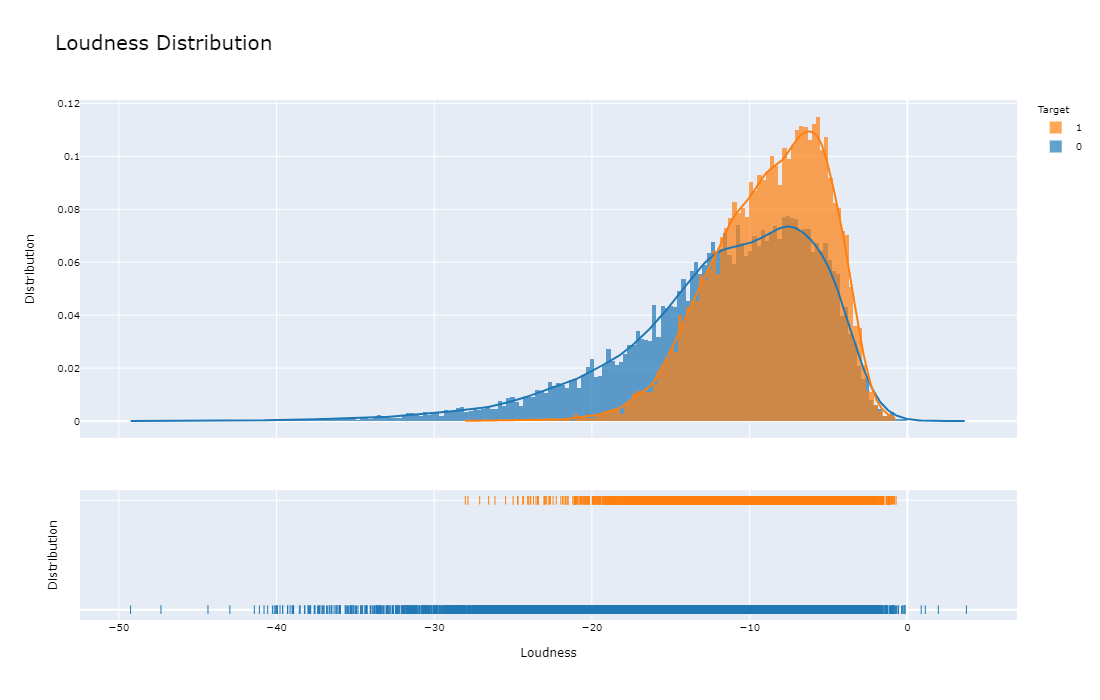

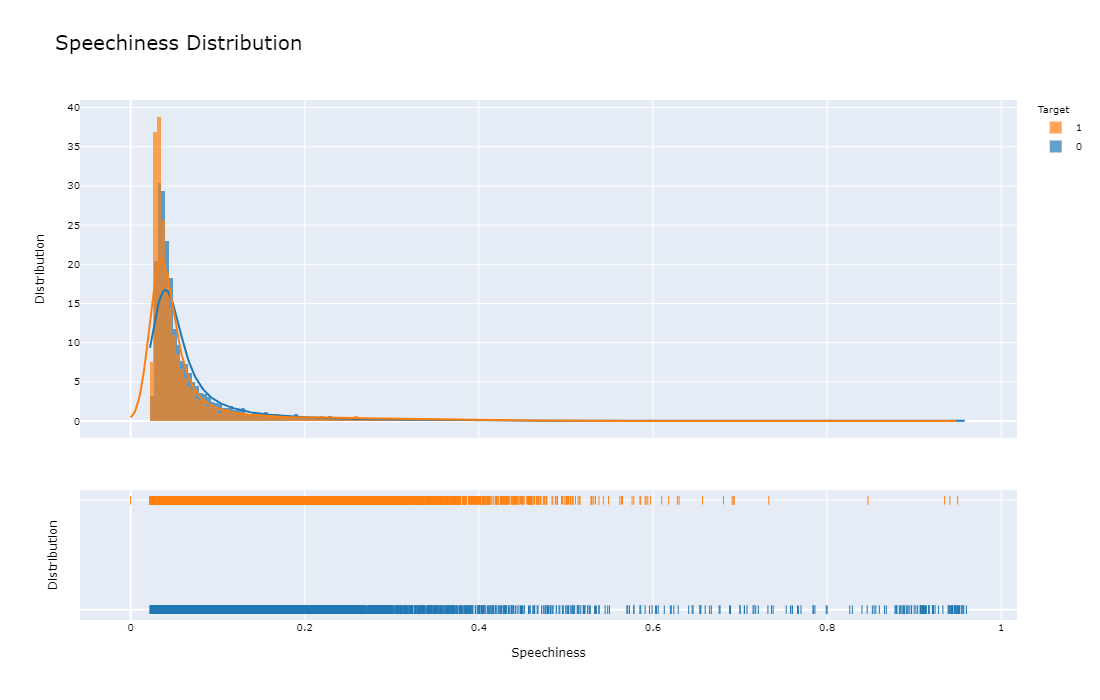

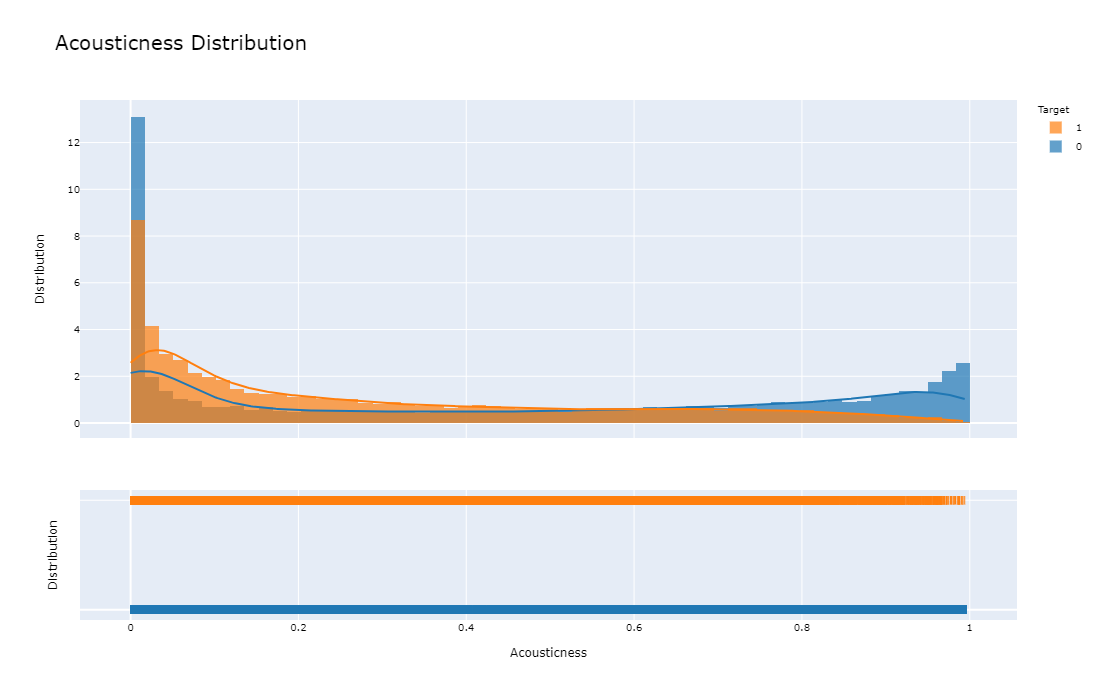

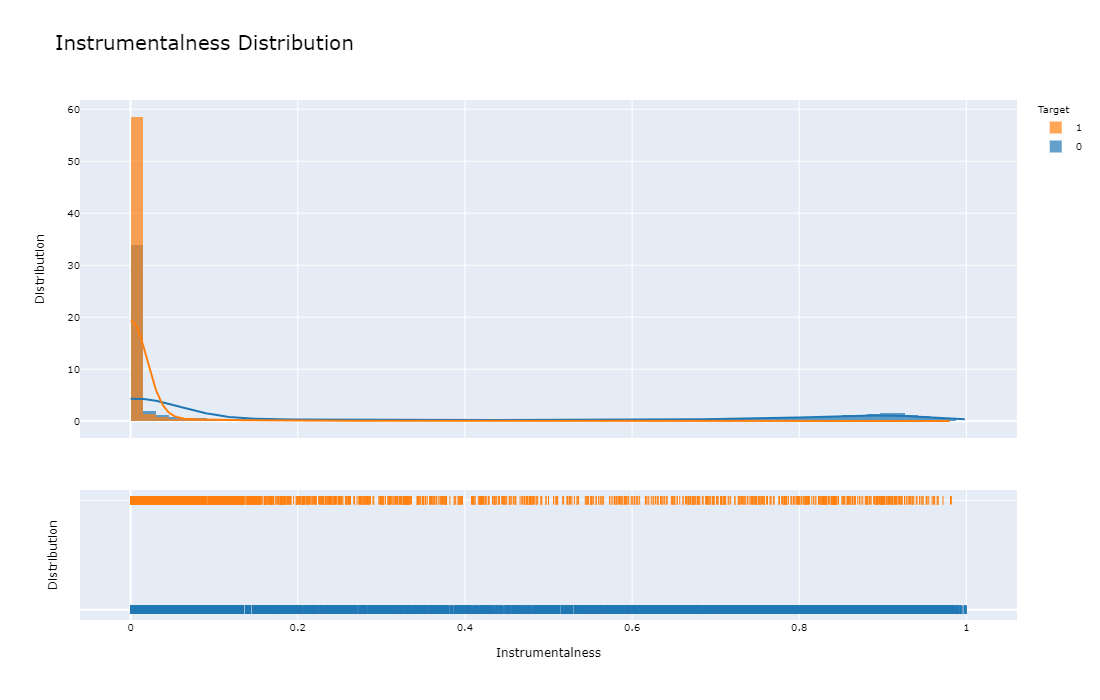

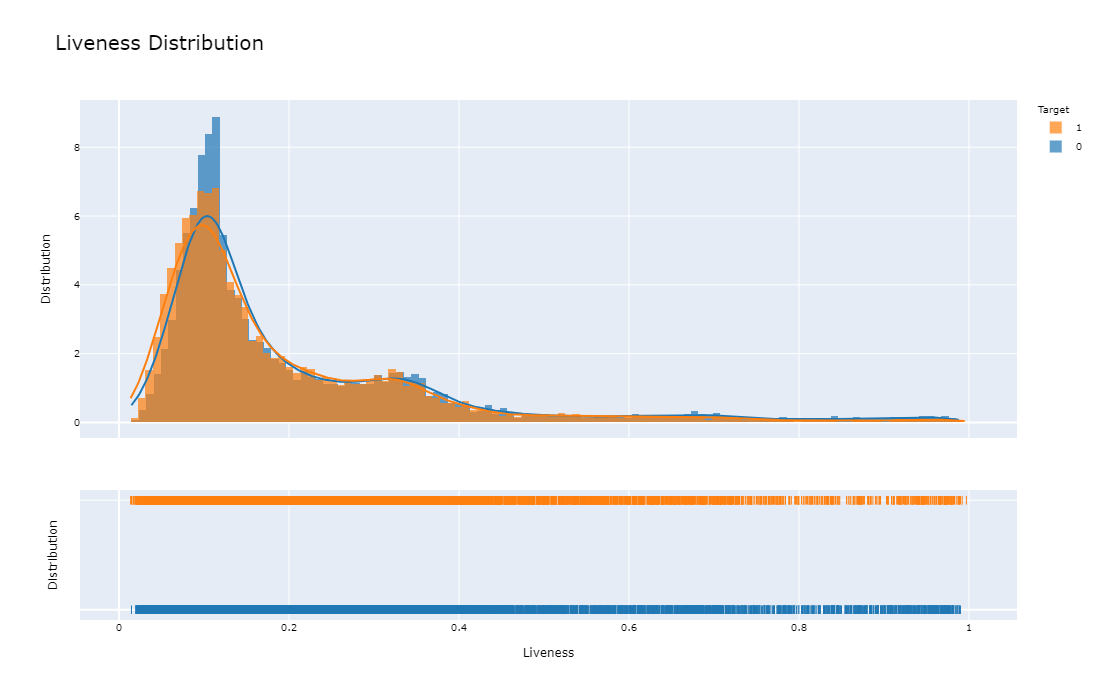

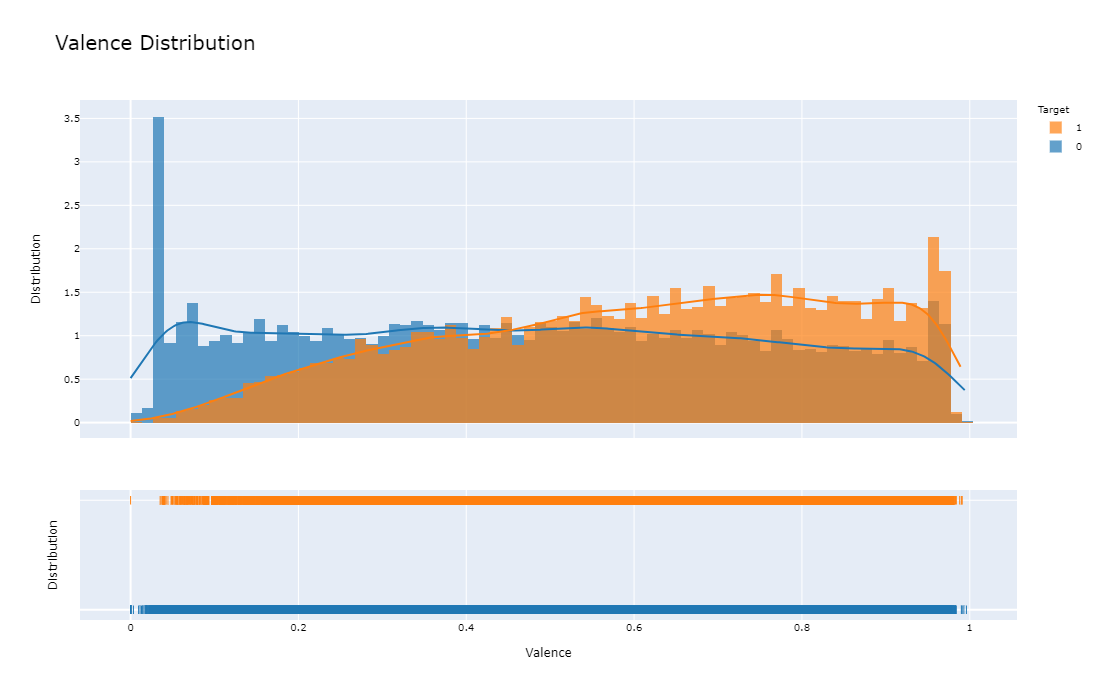

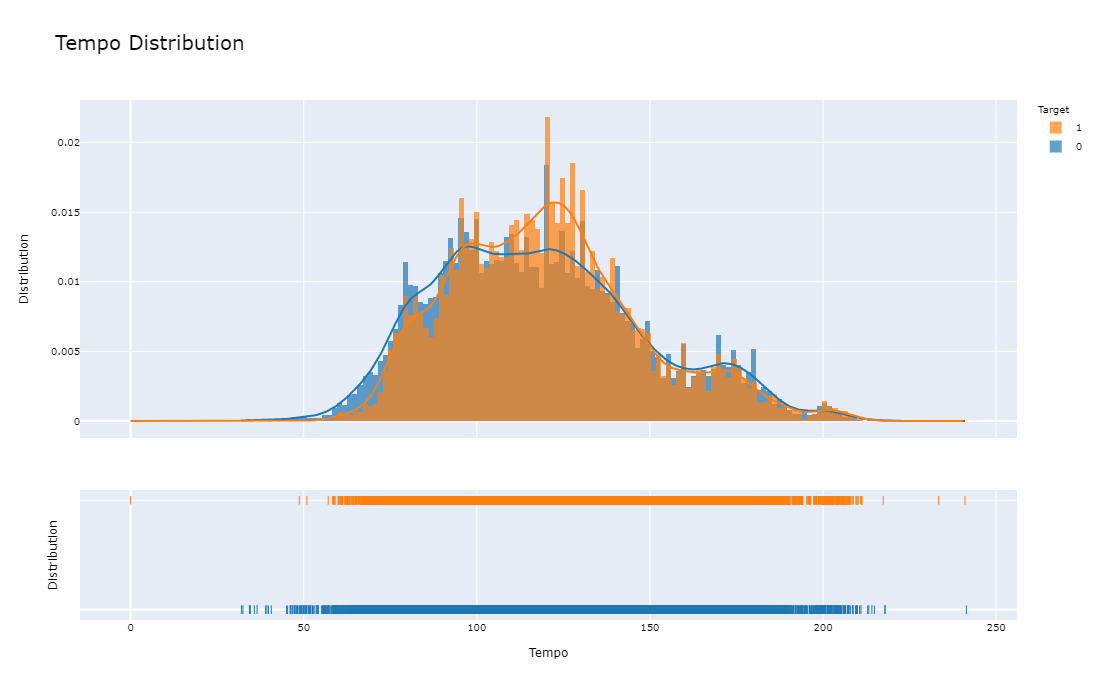

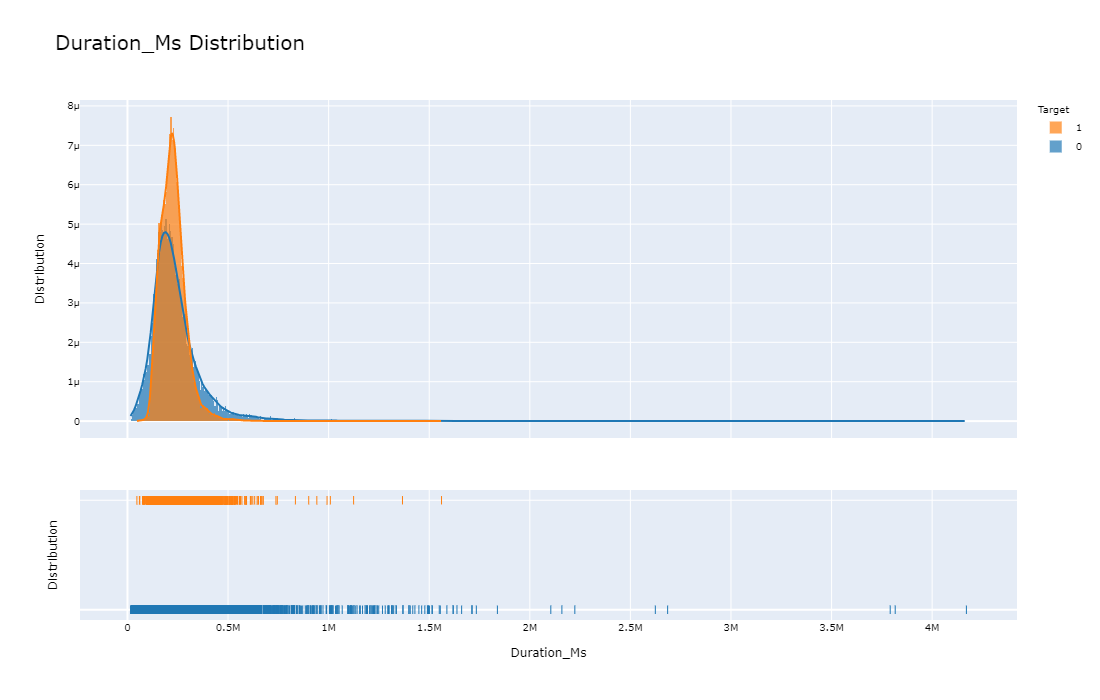

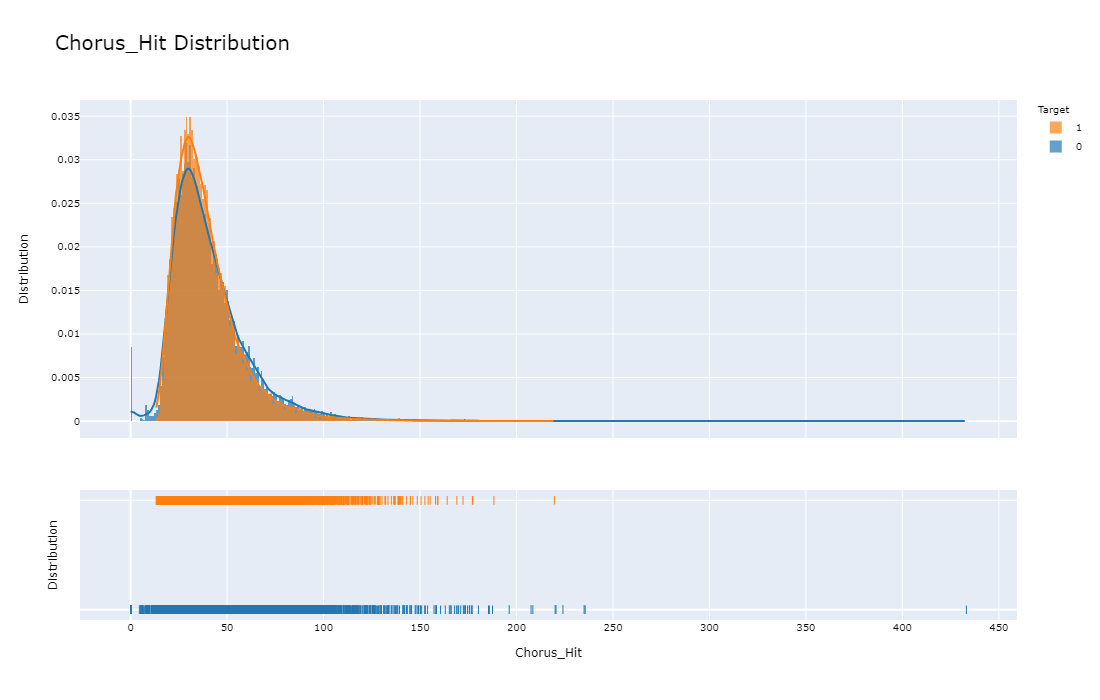

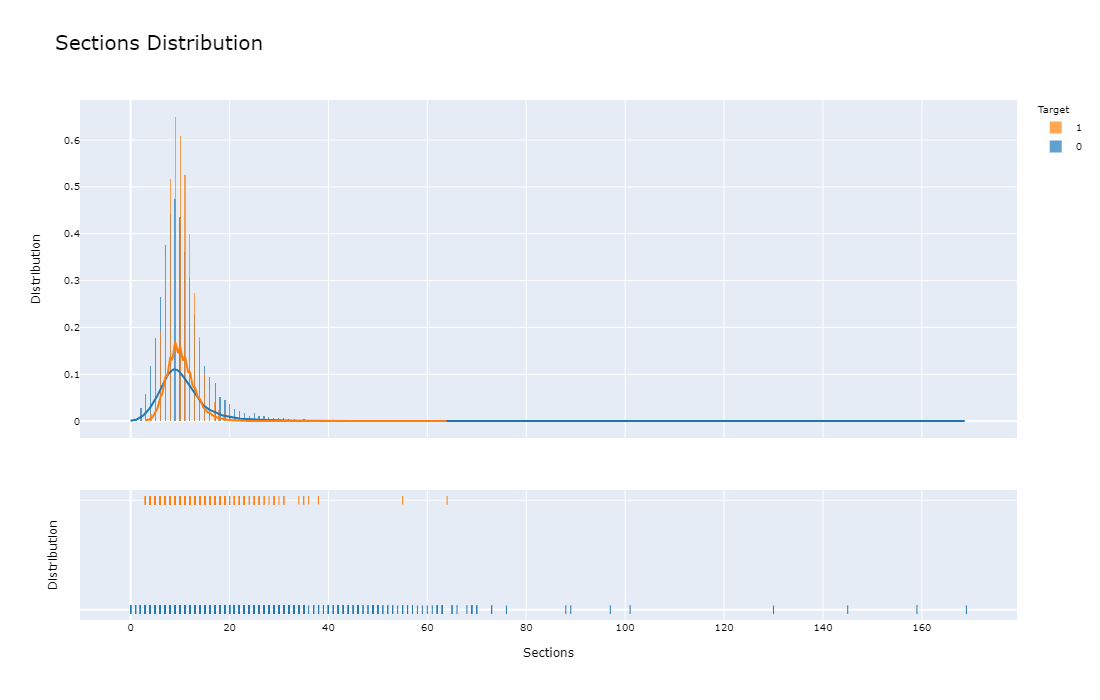

In [6]:
for Var in ContinuousVars:
    DistributionPlot(Train, Var)

## Testing combined variable impact on Target

- Songs that are hits tend to be more danceable and have higher energy together (No-Brainer)
- High Energy but undanceable songs are less likely to be hits, maybe particular Rock/Metal genres?
- Low energy Acoustic Songs tend to be Flops

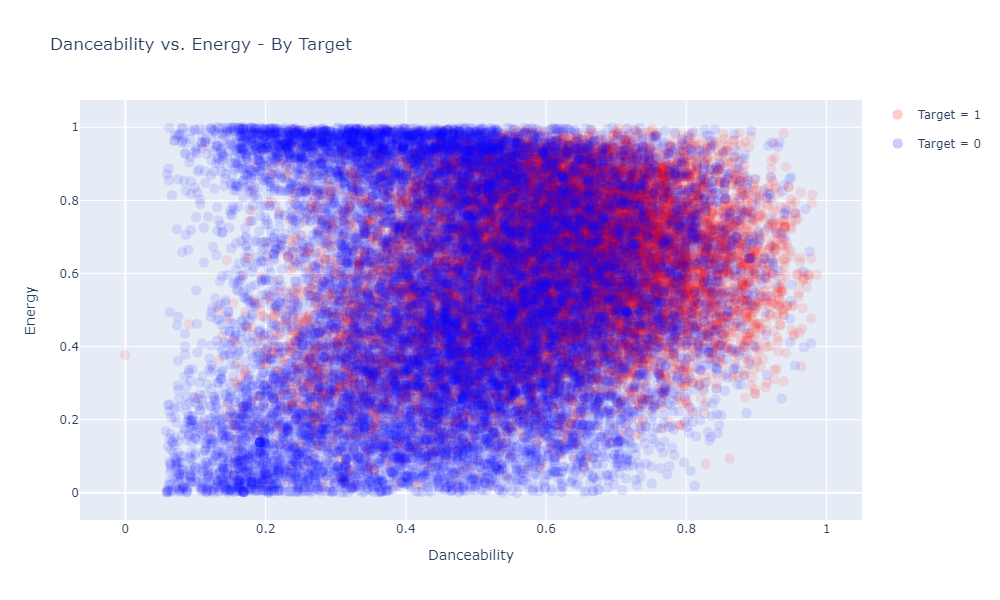

In [7]:
Scatter(Train, "Danceability", "Target", "Energy", "Danceability vs. Energy - By Target")

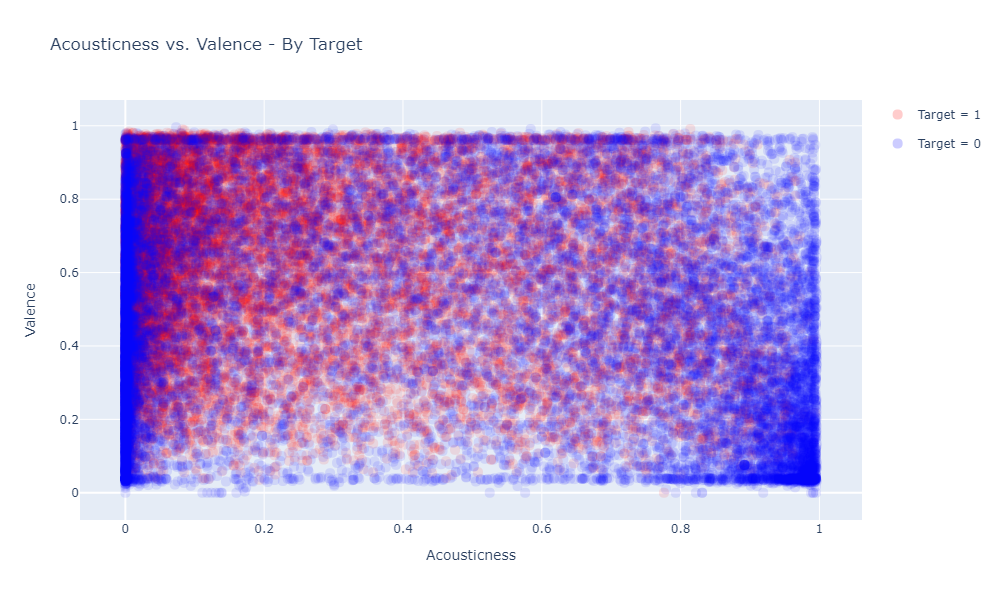

In [8]:
Scatter(Train, "Acousticness", "Target", "Valence", "Acousticness vs. Valence - By Target")

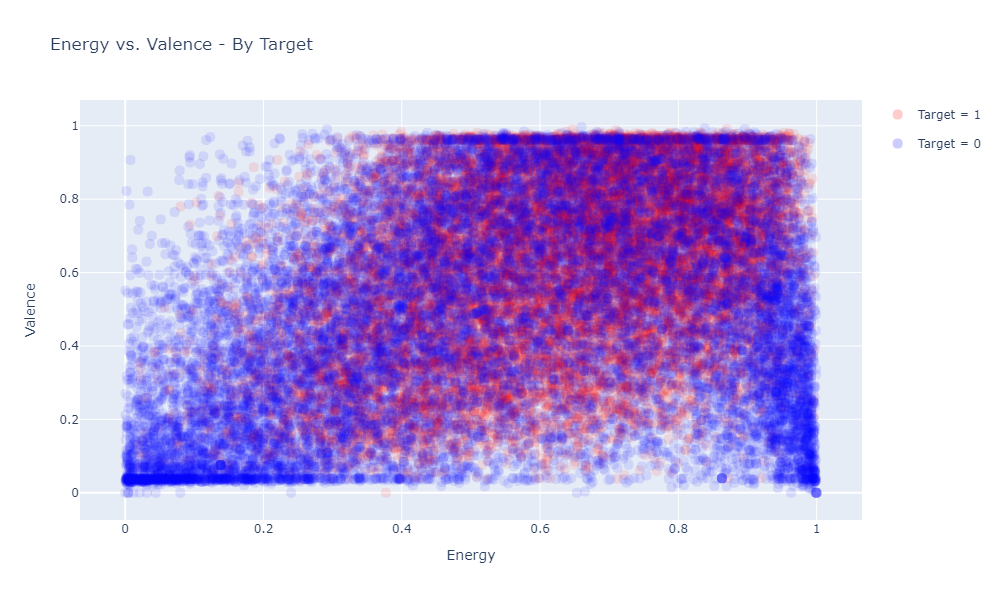

In [9]:
Scatter(Train, "Energy", "Target", "Valence", "Energy vs. Valence - By Target")

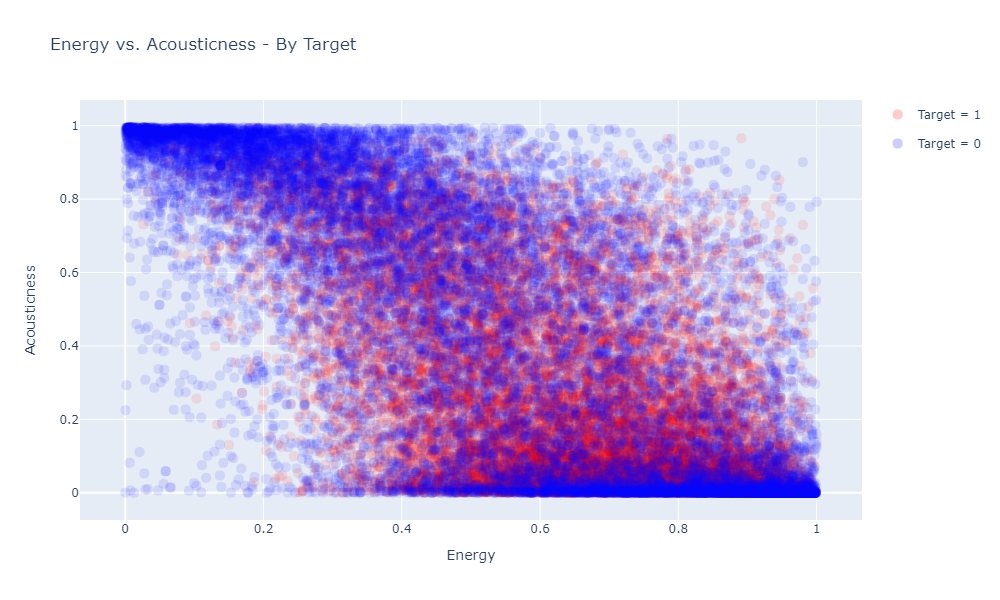

In [10]:
Scatter(Train, "Energy", "Target", "Acousticness", "Energy vs. Acousticness - By Target")

## Bin Variables and Clean
- We can see that, obviously, the most common signature is 4:4.
- We also see the host of non-linear relationships between features and the Target.

We use the optimal binning library in python to find the most optimal ways of binning our variables w.r.t the target. We bin our variables according to these definitions and scale them between 0 and 1, to help with gradient descent and assessing our feature importance.

We also ordinally encode the "Key" variable according to its relationship with the target.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




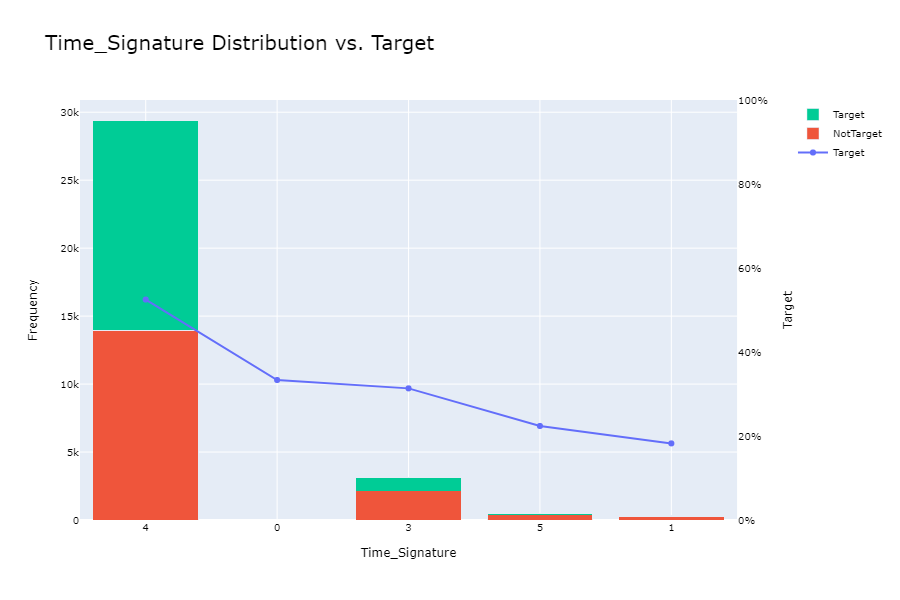

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




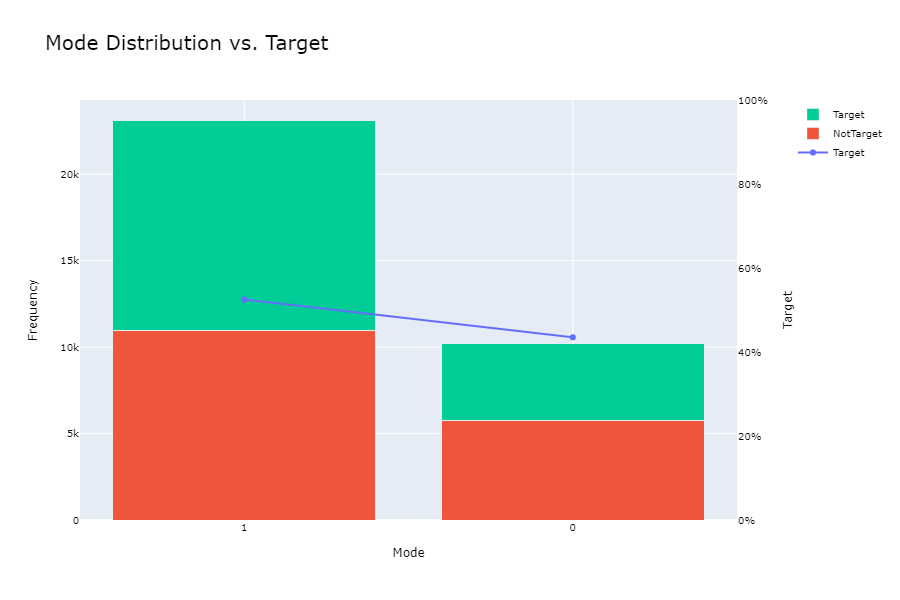

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




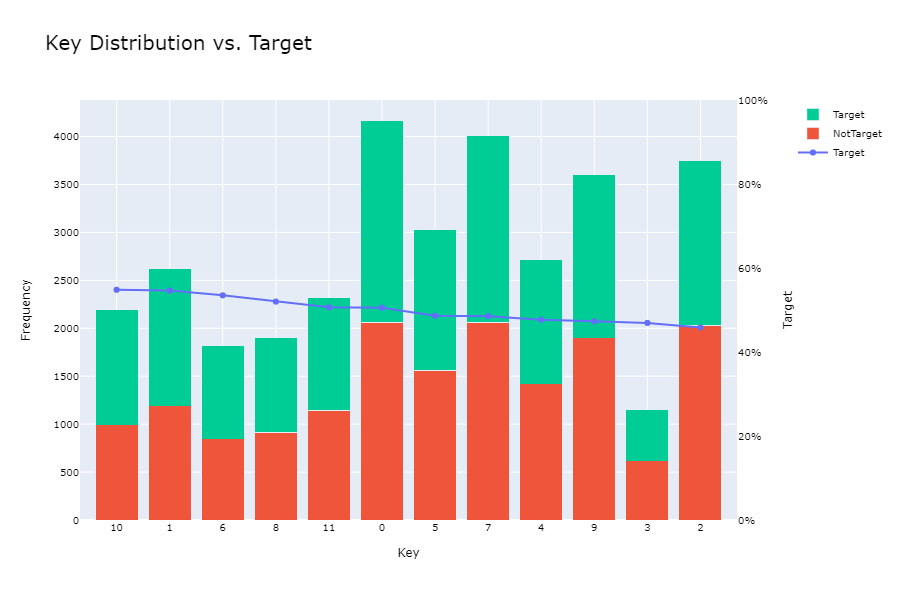

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




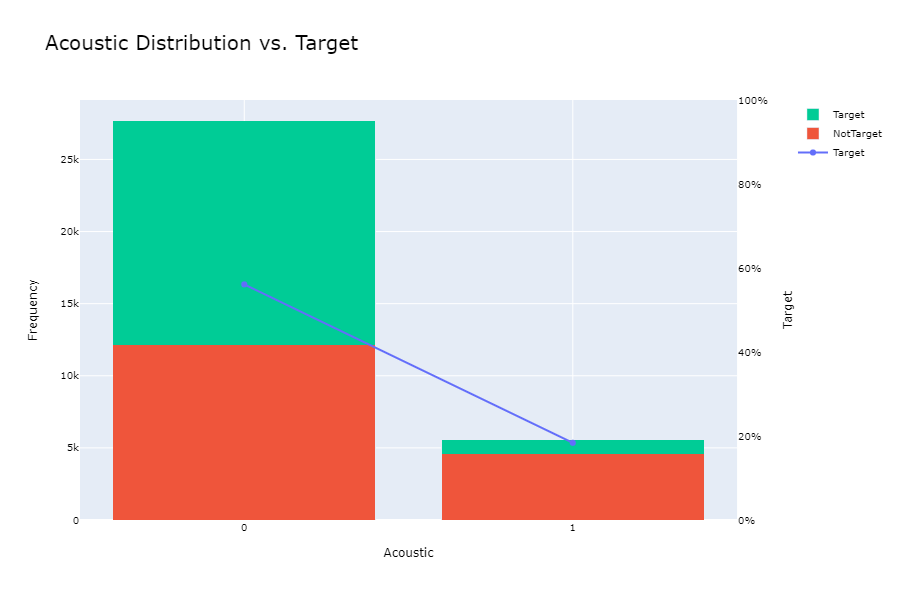

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




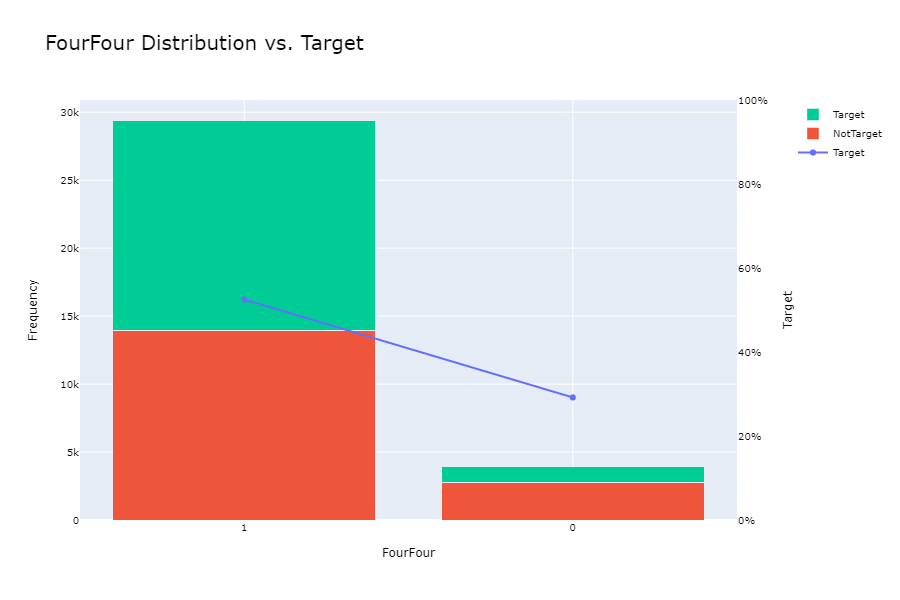

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




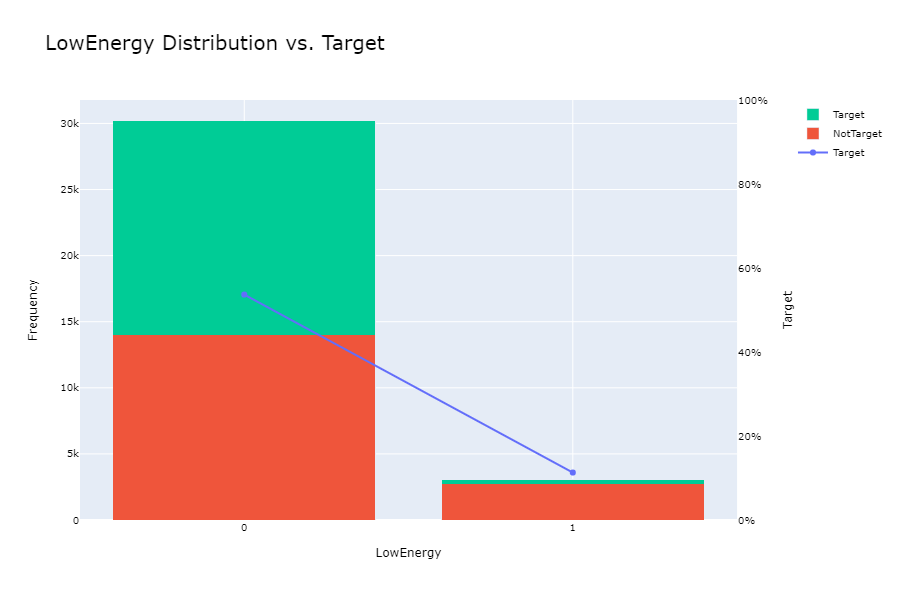

In [11]:
for Variable in DiscreteVars:
    Distribution(Train, "Target", Variable)

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.39286016
    IV (Jeffrey)             0.62423549
    JS (Jensen-Shannon)      0.06801395
    HHI                      0.04146907
    HHI (normalized)         0.01327699
    Cramer's V               0.35334771
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    14.362591  0.000151  0.000026  0.999974
         1      2     0.219058  0.639759  0.322821  0.677179
         2      3     4.229594  0.039725  0.018575  0.981425
         3      4     9.044575  0.002635  0.000895  0.999105
         4      5    11.047577  0.000888  0.000336  0.999664
         5      6     5.031113  0.024896  0.012176  0.987824
         6      7     0.600361  0.438440  0.221555  0.778445
         7      8     0.042047  0.837530  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




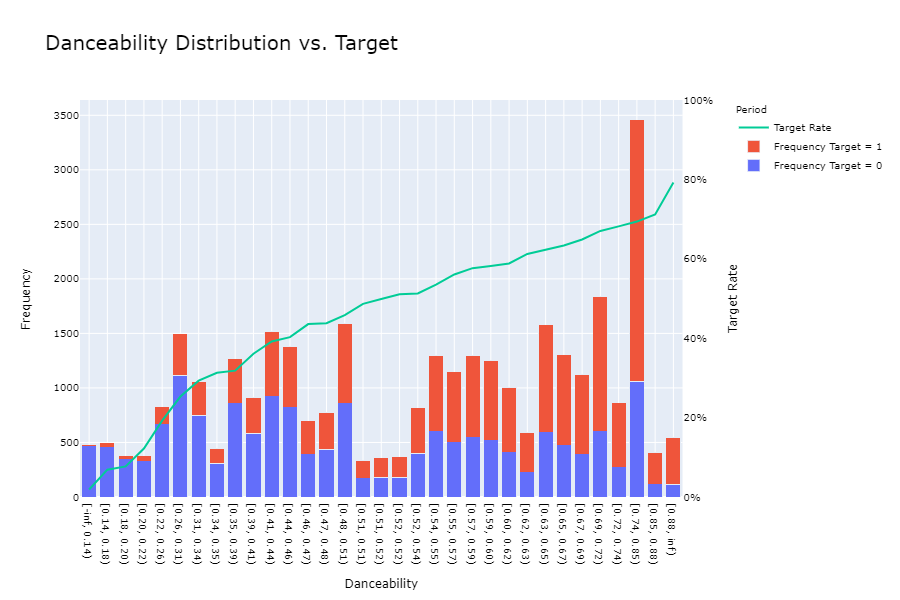

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.36930523
    IV (Jeffrey)             0.65967145
    JS (Jensen-Shannon)      0.07016773
    HHI                      0.07687757
    HHI (normalized)         0.04890417
    Cramer's V               0.35562257
    Quality score            0.00000874

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     0.327122  0.567359  0.283766  7.162338e-01
         1      2     7.660493  0.005644  0.001467  9.985332e-01
         2      3    12.248688  0.000466  0.000157  9.998435e-01
         3      4     5.718996  0.016782  0.007879  9.921209e-01
         4      5     3.359056  0.066836  0.033744  9.662560e-01
         5      6     1.372573  0.241370  0.119052  8.809483e-01
         6      7     0.319799  0.571729  0.286548  7.134521e-01
         7

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




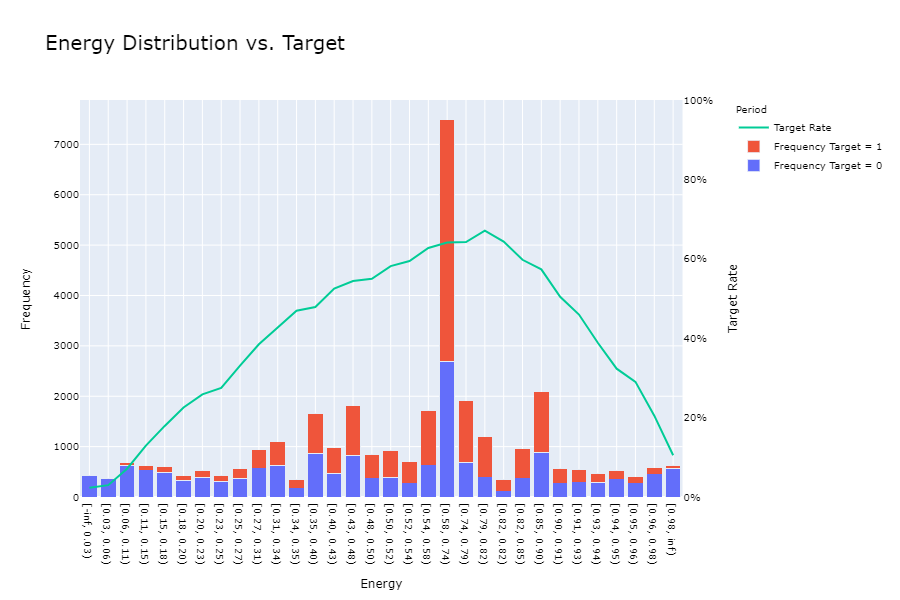

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28918558
    IV (Jeffrey)             0.57119718
    JS (Jensen-Shannon)      0.05471682
    HHI                      0.13431325
    HHI (normalized)         0.09968578
    Cramer's V               0.30793446
    Quality score            0.00000022

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1    14.070355  1.760975e-04  2.096657e-05  0.999979
         1      2    10.127560  1.460687e-03  6.546622e-04  0.999345
         2      3     3.523586  6.050140e-02  3.030943e-02  0.969691
         3      4     1.613955  2.039367e-01  1.006569e-01  0.899343
         4      5     7.872479  5.019279e-03  2.080288e-03  0.997920
         5      6     0.903616  3.418140e-01  1.681983e-01  0.831802
         6      7    13.541166  2.333874e-04  7

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




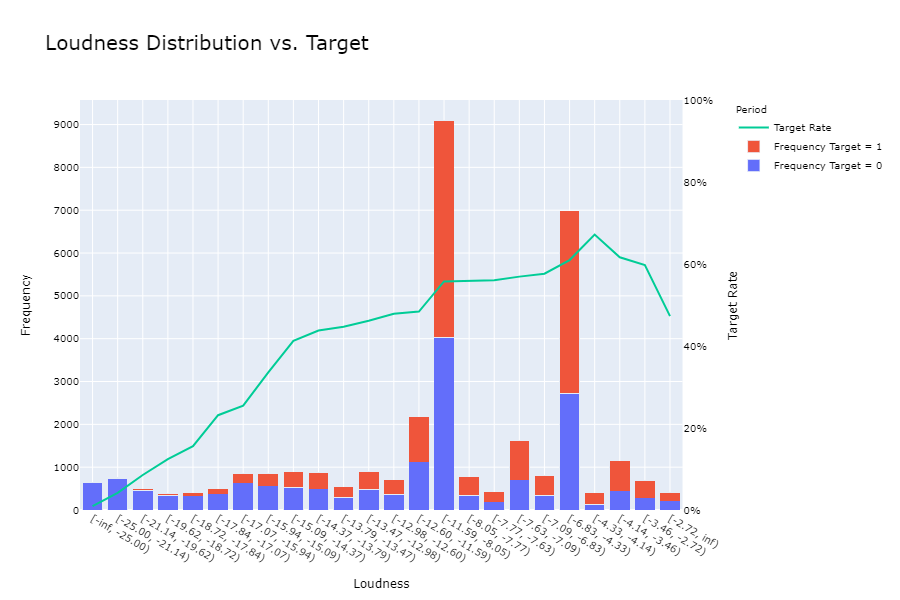

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16903398
    IV (Jeffrey)             0.14162262
    JS (Jensen-Shannon)      0.01715805
    HHI                      0.40680099
    HHI (normalized)         0.36972606
    Cramer's V               0.18274461
    Quality score            0.00003910

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     3.640530  0.056389  0.974506  2.549403e-02
         1      2     8.101386  0.004423  0.998141  1.859321e-03
         2      3     1.084966  0.297589  0.854171  1.458293e-01
         3      4     2.688288  0.101088  0.949525  5.047472e-02
         4      5     0.002808  0.957741  0.519930  4.800698e-01
         5      6     0.391869  0.531319  0.734821  2.651792e-01
         6      7     0.924912  0.336189  0.832686  1.673139e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




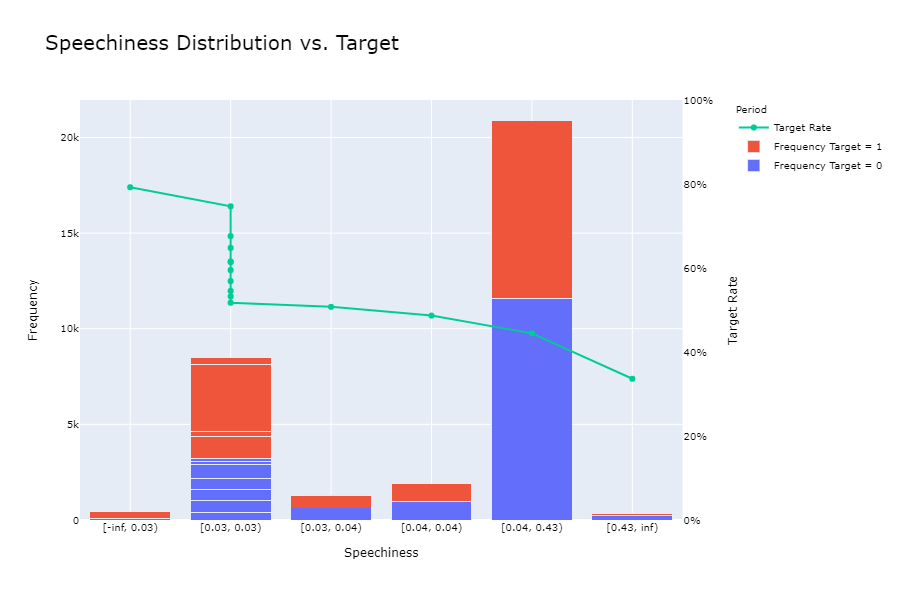

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.44669861
    IV (Jeffrey)             0.96951537
    JS (Jensen-Shannon)      0.09556714
    HHI                      0.03851982
    HHI (normalized)         0.01448282
    Cramer's V               0.41039361
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1     7.645248  5.692208e-03  1.403468e-03  0.998597
         1      2    22.546914  2.050737e-06  1.230738e-07  1.000000
         2      3    24.682908  6.758088e-07  3.267610e-08  1.000000
         3      4     1.154058  2.827013e-01  1.408042e-01  0.859196
         4      5     4.262942  3.895241e-02  1.846033e-02  0.981540
         5      6    11.445666  7.166096e-04  2.503227e-04  0.999750
         6      7     0.435286  5.094066e-01  2

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




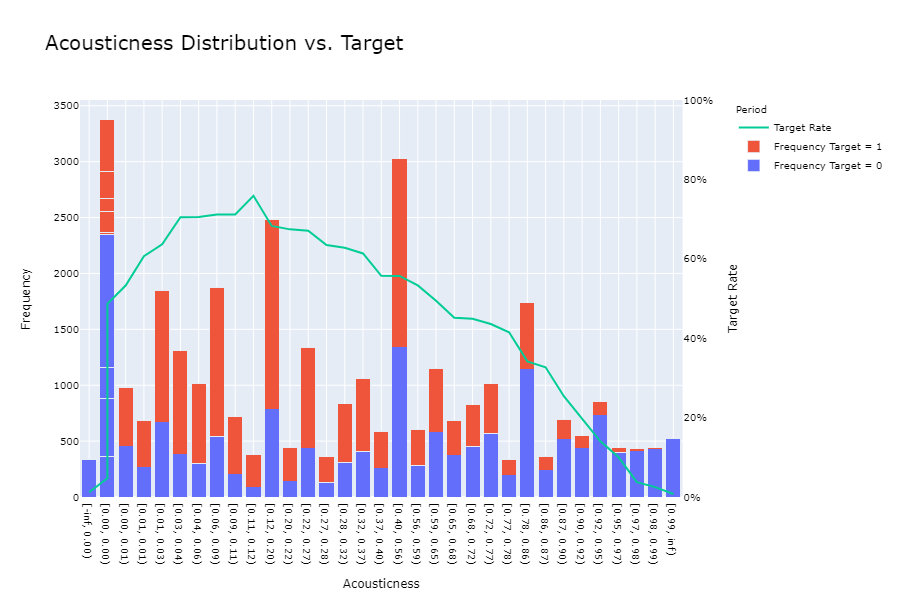

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.48163226
    IV (Jeffrey)             1.10142332
    JS (Jensen-Shannon)      0.11542494
    HHI                      0.11024754
    HHI (normalized)         0.07847066
    Cramer's V               0.45273455
    Quality score            0.00000008

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1    20.541836  0.000006  1.000000  7.285607e-08
         1      2     1.340555  0.246936  0.875525  1.244752e-01
         2      3     0.366812  0.544747  0.727220  2.727796e-01
         3      4     0.237674  0.625891  0.687029  3.129711e-01
         4      5     1.061023  0.302982  0.848323  1.516765e-01
         5      6     0.422361  0.515761  0.743285  2.567146e-01
         6      7     1.802309  0.179434  0.910372  8.962845e-02
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




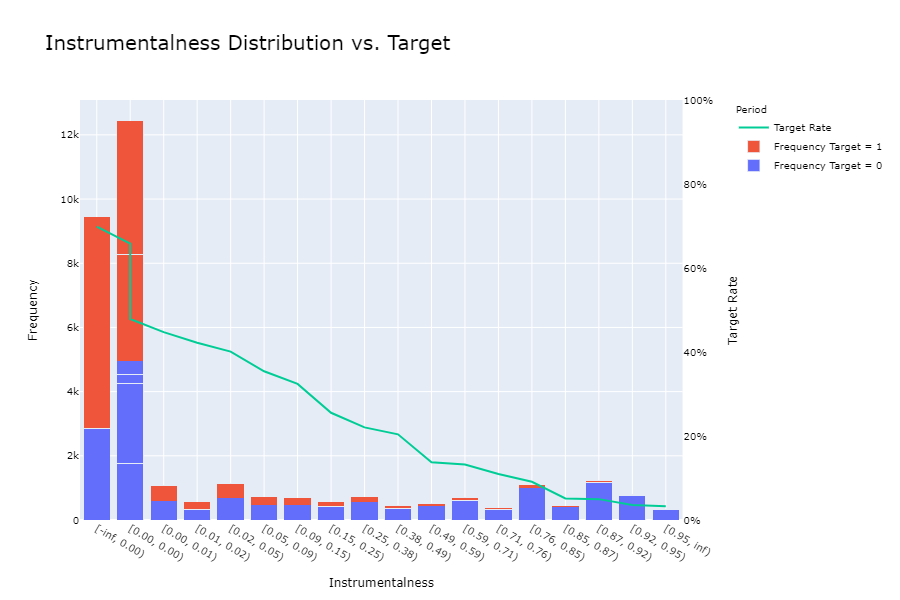

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08506328
    IV (Jeffrey)             0.04524584
    JS (Jensen-Shannon)      0.00557439
    HHI                      0.42162170
    HHI (normalized)         0.36904185
    Cramer's V               0.10488870
    Quality score            0.02515710

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     3.898095  0.048341  0.976555  0.023445
         1      2     1.887754  0.169455  0.915184  0.084816
         2      3     0.560728  0.453967  0.772996  0.227004
         3      4     5.747654  0.016511  0.992124  0.007876
         4      5     0.777976  0.377761  0.811510  0.188490
         5      6     7.850682  0.005080  0.997478  0.002522
         6      7     1.820509  0.177253  0.911482  0.088518
         7      8     8.591399  0.003378  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




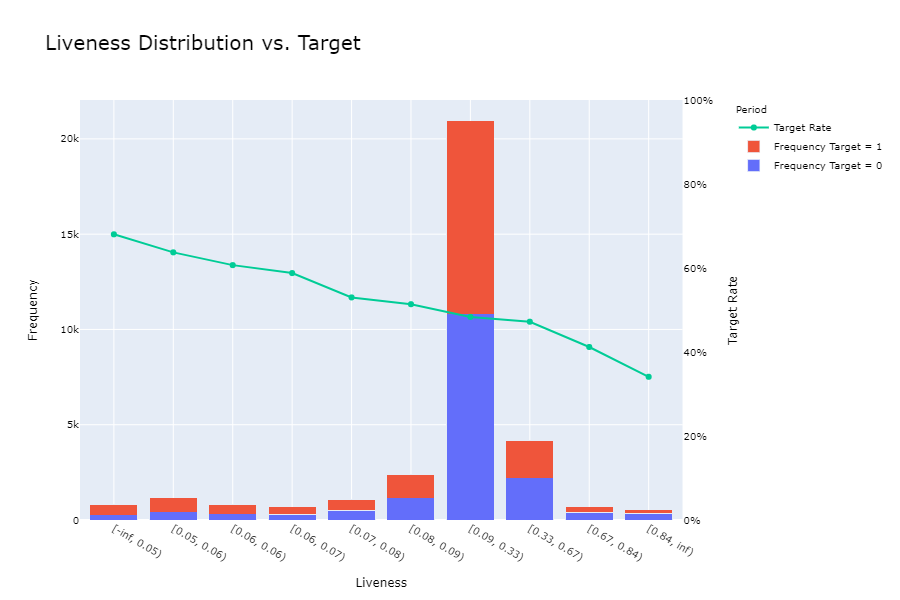

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28042367
    IV (Jeffrey)             0.49863926
    JS (Jensen-Shannon)      0.04669572
    HHI                      0.08476859
    HHI (normalized)         0.04663395
    Cramer's V               0.28540173
    Quality score            0.00000051

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1    11.320810  7.664327e-04  1.637914e-04  0.999836
         1      2    12.334652  4.446269e-04  1.394498e-04  0.999861
         2      3     0.197223  6.569718e-01  3.245272e-01  0.675473
         3      4    30.164844  3.968382e-08  1.931653e-09  1.000000
         4      5     7.348625  6.711407e-03  3.114551e-03  0.996885
         5      6     5.149107  2.325833e-02  1.086206e-02  0.989138
         6      7     2.963273  8.517534e-02  4.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




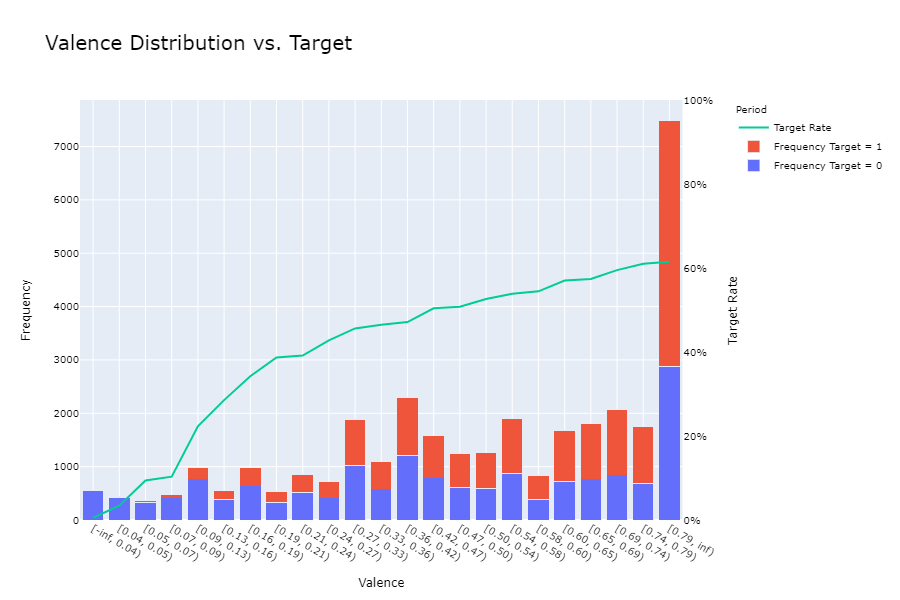

UNKNOWN
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Significance tests

    None

None


C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




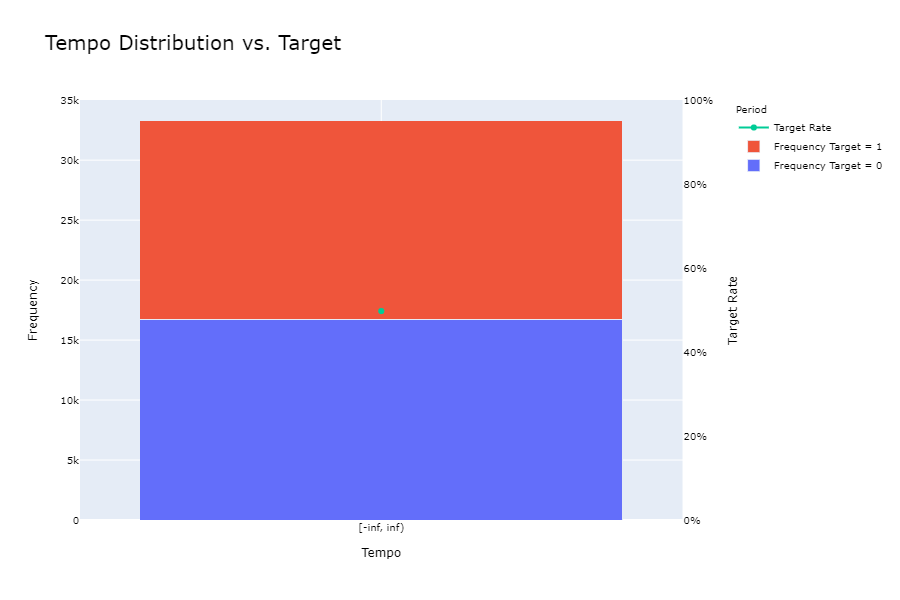

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.29291133
    IV (Jeffrey)             0.51868275
    JS (Jensen-Shannon)      0.05085807
    HHI                      0.05886206
    HHI (normalized)         0.03034273
    Cramer's V               0.29894899
    Quality score            0.00000011

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1     6.678592  9.757766e-03  3.287252e-03  9.967127e-01
         1      2     3.961470  4.655305e-02  2.064300e-02  9.793570e-01
         2      3    27.858097  1.305466e-07  4.897555e-09  1.000000e+00
         3      4    23.120037  1.521964e-06  1.278877e-07  9.999999e-01
         4      5     2.556673  1.098295e-01  5.346559e-02  9.465344e-01
         5      6     0.527749  4.675547e-01  2.346324e-01  7.653676e-01
         6      7  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




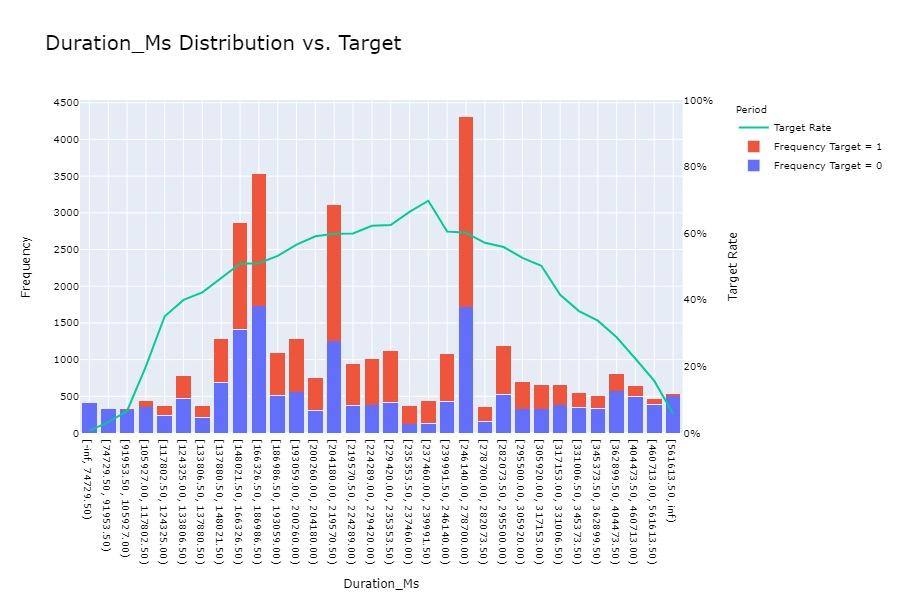

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07166046
    IV (Jeffrey)             0.05040628
    JS (Jensen-Shannon)      0.00547170
    HHI                      0.22670176
    HHI (normalized)         0.14937194
    Cramer's V               0.09916549
    Quality score            0.00000209

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1   238.223668  9.594695e-54  2.265751e-62  1.000000
         1      2     0.045090  8.318391e-01  4.157620e-01  0.584238
         2      3     0.065731  7.976563e-01  3.988026e-01  0.601197
         3      4     0.001868  9.655261e-01  4.827810e-01  0.517219
         4      5     0.022227  8.814837e-01  4.405677e-01  0.559432
         5      6     0.041196  8.391595e-01  4.195317e-01  0.580468
         6      7     9.589448  1.956988e-03  9

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




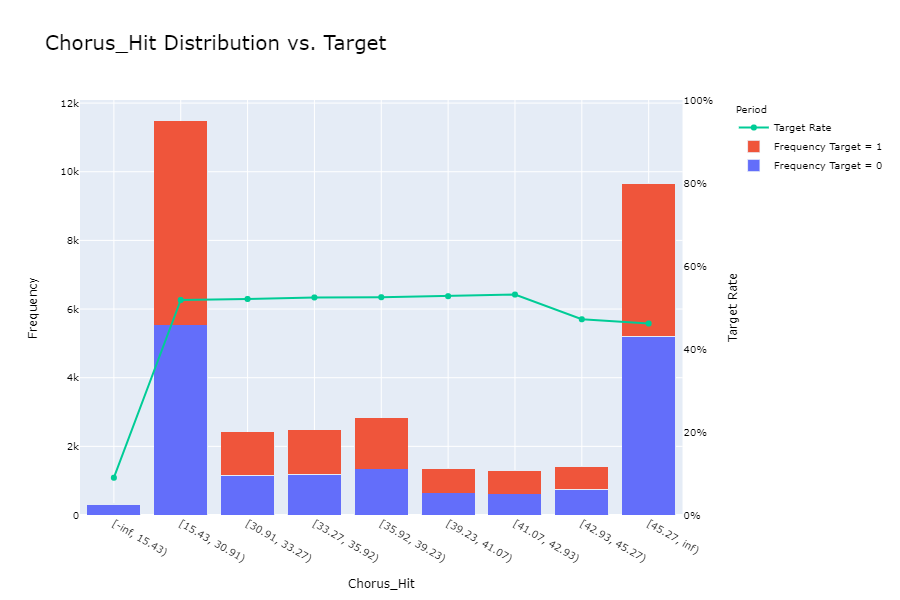

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23433830
    IV (Jeffrey)             0.34287703
    JS (Jensen-Shannon)      0.03642778
    HHI                      0.08942269
    HHI (normalized)         0.04149757
    Cramer's V               0.25539421
    Quality score            0.12555354

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1    15.987660  6.375670e-05  9.480732e-06  9.999905e-01
         1      2    48.639689  3.075811e-12  1.474049e-14  1.000000e+00
         2      3    60.131121  8.874402e-15  3.487977e-17  1.000000e+00
         3      4    19.894022  8.185590e-06  2.189094e-06  9.999978e-01
         4      5    19.250911  1.146157e-05  2.730810e-06  9.999973e-01
         5      6    13.215348  2.776660e-04  9.716790e-05  9.999028e-01
         6      7   

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




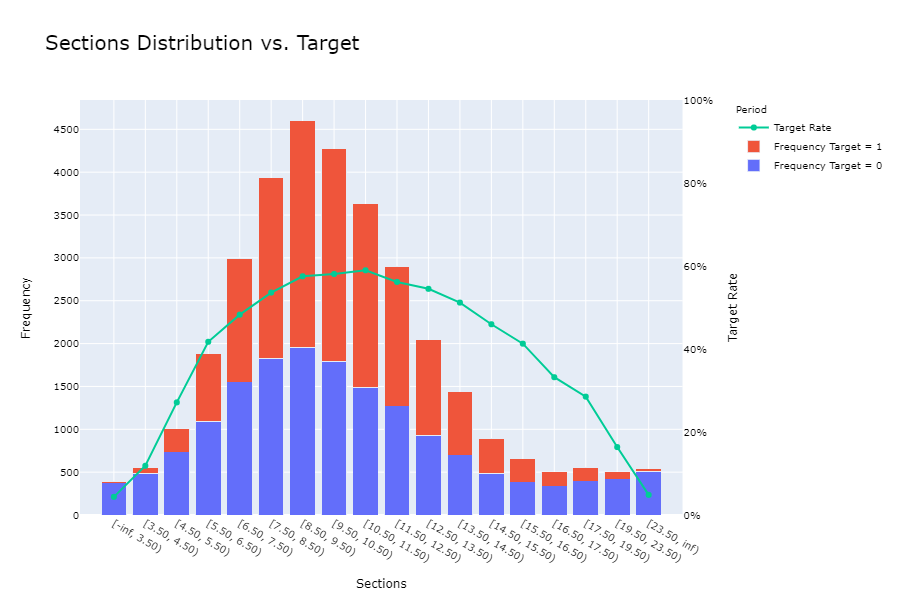

In [12]:
BinOut = {}

for Variable in ContinuousVars:
    BinOut = BinVariable(Train, "Target", Variable, BinOut, Trend="auto")

In [13]:
Variables = ["Mode", "Acoustic", "FourFour", "LowEnergy", "Liveness", "Instrumentalness", "Danceability"]

SquareVariables = ["Loudness", "Duration_Ms", "Energy", "Acousticness", "Tempo", "Sections"]

SqrtVariables = ["Valence"]

OrdinalVariables = ["Key"]

ModVars = Variables+SquareVariables+SqrtVariables+OrdinalVariables
ModVarsClean = [str(Variable)+"Clean" for Variable in ModVars]

In [14]:
for Variable in ModVars:
    Train[Variable+"Clean"] = Train[Variable]
    Test[Variable+"Clean"] = Test[Variable]

In [15]:
for Variable in ContinuousVars:
    
    Bins = BinOut[Variable].tolist()
    Bins.insert(0, -np.inf)
    Bins.insert(len(Bins), np.inf)
    
    Train[Variable + "Clean"] = pd.cut(Train[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values
    Test[Variable + "Clean"] = pd.cut(Test[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values

In [16]:
for Variable in ModVarsClean:
    Train[Variable]  = pd.to_numeric(Train[Variable])
    Test[Variable]  = pd.to_numeric(Test[Variable])

for Variable in SquareVariables:
    Train[str(Variable)+"SquaredClean"] = Train[Variable+"Clean"]**2
    Test[str(Variable)+"SquaredClean"] = Test[Variable+"Clean"]**2
    ModVarsClean.append(str(Variable)+"SquaredClean")
    
for Variable in SqrtVariables:
    Train[str(Variable)+"SqrtClean"] = Train[Variable+"Clean"]**0.5
    Test[str(Variable)+"SqrtClean"] = Test[Variable+"Clean"]**0.5
    ModVarsClean.append(str(Variable)+"SqrtClean")
    
for Variable in OrdinalVariables:
    Index = pd.pivot_table(Train, index=Variable, values="Target", aggfunc="mean").sort_values(by="Target", ascending=False).index.values
    Labels = {}
    for i in range(len(Index)):
        Labels[Index[i]] = i

    Train[str(Variable)+"Clean"] = Train.Key.map(Labels)
    Test[str(Variable)+"Clean"] = Test.Key.map(Labels)

In [17]:
for Variable in ModVarsClean:
    Scaler = MinMaxScaler(feature_range=(-1, 1))
    Scaler = Scaler.fit(Train[Variable].values.reshape(-1, 1))
    Train[Variable] = Scaler.transform(Train[Variable].values.reshape(-1, 1))
    Test[Variable] = Scaler.transform(Test[Variable].values.reshape(-1, 1))

## Variable Correlations

In [18]:
Correlation(Train, sorted(ModVarsClean)+["Target"], "CorrelationPlot")

In [19]:
OverFit = []
for i in Train.columns:
    Counts = Train[i].value_counts()
    Zeros = Counts.iloc[0]
    if Zeros / len(Train) * 100 > 99.94:
        OverFit.append(i)
        print(Counts)

OverFit = list(OverFit)
print(OverFit)
#Train = Train.drop(OverFit, axis=1)
#print(Train.shape)

Train    33263
Name: Population, dtype: int64
-1.0    33263
Name: TempoClean, dtype: int64
-1.0    33263
Name: TempoSquaredClean, dtype: int64
['Population', 'TempoClean', 'TempoSquaredClean']


## Modelling

We choose our selection of classifiers:

- Logistic Regression
- Decision Tree
- Random Forest

We then perform a grid search on each (not including logistic regression) to find the optimal parameters and plot feature importances. Finally, we compare our models using a series of metrics.

As the variables have been scaled between -1 and 1, the coefficients in the logistic regression model allow us to see feature importances. We can see that the two most important variables in determining the target are Duration and Energy. When fitting this model, l1 (Lasso) regularisation was used, meaning the fitting process would shrink any irrelevant coefficients to 0 and therefore performing feature selection, however, all features were significant.

In both the Decision Tree and the Random Forest classifiers, a grid search was used to determine the optimal parameters. This increased training time down to the fact that grid search is exhaustive, testing all possible combinations of the parameter grid. The parameter grid included max_depth and n_samples_split. n_estimators was used for the Random Forest Classifier.

- max_depth: Maximum depth of the tree, or number of layers of splits/nodes.
- min_samples_split: Minimum number of samples required to split a node further.
- 

In [61]:
X = ['AcousticClean', 'DanceabilityClean', 'Duration_MsClean', 'Duration_MsSquaredClean'
                , 'EnergyClean', 'EnergySquaredClean', 'FourFourClean', 'InstrumentalnessClean', 'KeyClean'
                , 'LivenessClean', 'LoudnessClean', 'LoudnessSquaredClean', 'LowEnergyClean', 'ModeClean'
                , 'SectionsClean', 'SectionsSquaredClean', 'ValenceClean', 'ValenceSqrtClean']

Y = "Target"

In [21]:
Scores = {}
Precisions = {}
Recalls = {}
Aucs = {}

### Logistic Regression

In [87]:
Mod = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

In [88]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.coef_[0][i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

In [24]:
Aucs["LogisticRegressionTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["LogisticRegressionTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["LogisticRegressionTrain"] = precision_score(TrainPreds, Train[Y])
Scores["LogisticRegressionTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["LogisticRegressionTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["LogisticRegressionTest"] = recall_score(TestPreds, Test[Y])
Precisions["LogisticRegressionTest"] = precision_score(TestPreds, Test[Y])
Scores["LogisticRegressionTest"] = accuracy_score(TestPreds, Test[Y])

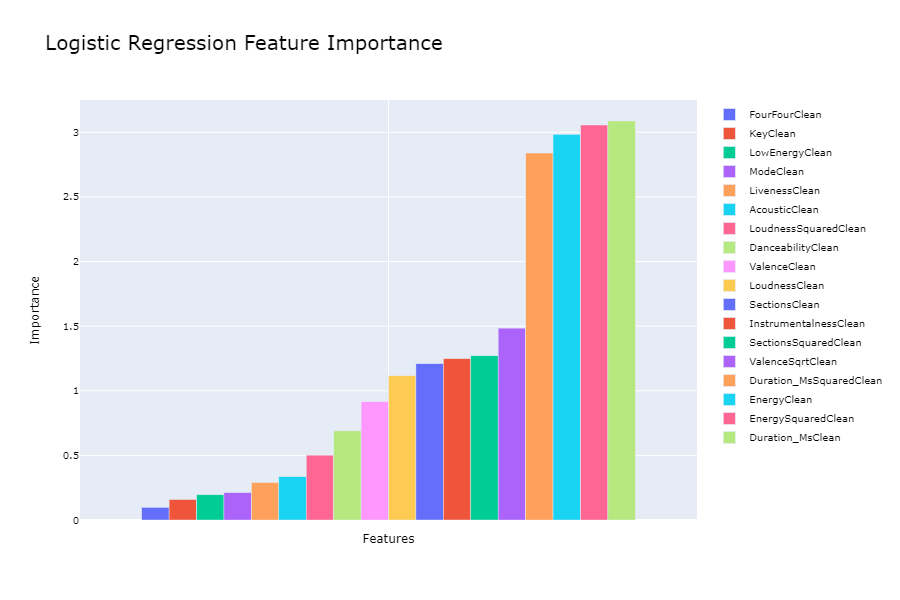

In [25]:
BarPlot(FeatureImportance, "Logistic Regression Feature Importance")

### Decision Tree

In [26]:
ParamGrid = {'max_depth': np.arange(3, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 10)]
            }

Mod = GridSearchCV(tree.DecisionTreeClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Decision Tree Best Params: {}'.format(Mod.best_params_))

Mod = tree.DecisionTreeClassifier(max_depth = Mod.best_params_["max_depth"]
                                  , min_samples_split = Mod.best_params_["min_samples_split"])
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Decision Tree Best Params: {'max_depth': 8, 'min_samples_split': 332}


In [27]:
Aucs["DecisionTreeTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["DecisionTreeTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["DecisionTreeTrain"] = precision_score(TrainPreds, Train[Y])
Scores["DecisionTreeTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["DecisionTreeTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["DecisionTreeTest"] = recall_score(TestPreds, Test[Y])
Precisions["DecisionTreeTest"] = precision_score(TestPreds, Test[Y])
Scores["DecisionTreeTest"] = accuracy_score(TestPreds, Test[Y])

In [28]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

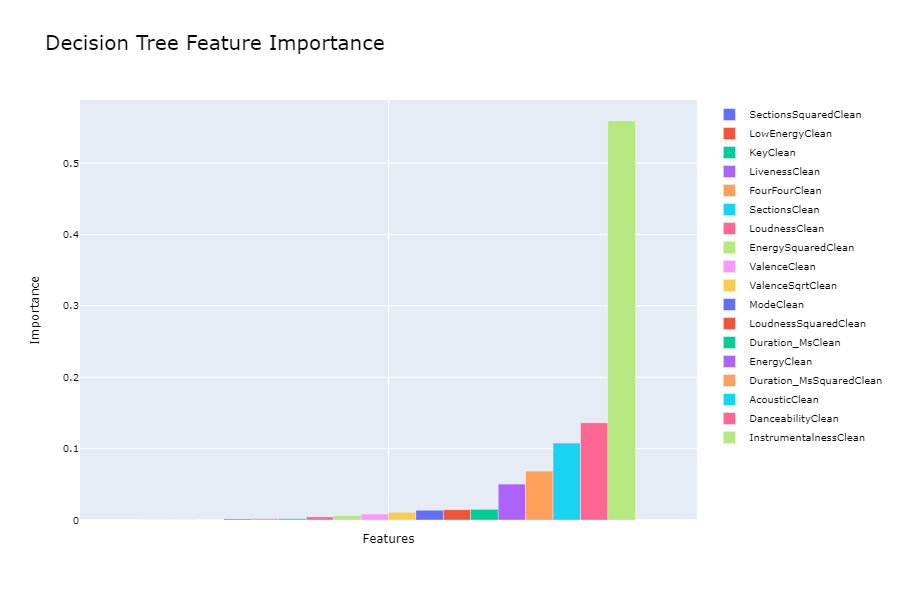

In [29]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

### Random Forest

In [62]:
ParamGrid = {'n_estimators': np.arange(100, 200, 50)
             , 'max_depth': np.arange(5, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 5)]
            }

Mod = GridSearchCV(RandomForestClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Random Forest Best Params: {}'.format(Mod.best_params_))

Mod = RandomForestClassifier(max_depth = Mod.best_params_["max_depth"]
                             , n_estimators = Mod.best_params_["n_estimators"]
                             , min_samples_split = Mod.best_params_["min_samples_split"])

Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Random Forest Best Params: {'max_depth': 9, 'min_samples_split': 332, 'n_estimators': 150}


In [67]:
Aucs["RandomForestTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["RandomForestTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["RandomForestTrain"] = precision_score(TrainPreds, Train[Y])
Scores["RandomForestTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["RandomForestTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["RandomForestTest"] = recall_score(TestPreds, Test[Y])
Precisions["RandomForestTest"] = precision_score(TestPreds, Test[Y])
Scores["RandomForestTest"] = accuracy_score(TestPreds, Test[Y])

In [68]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

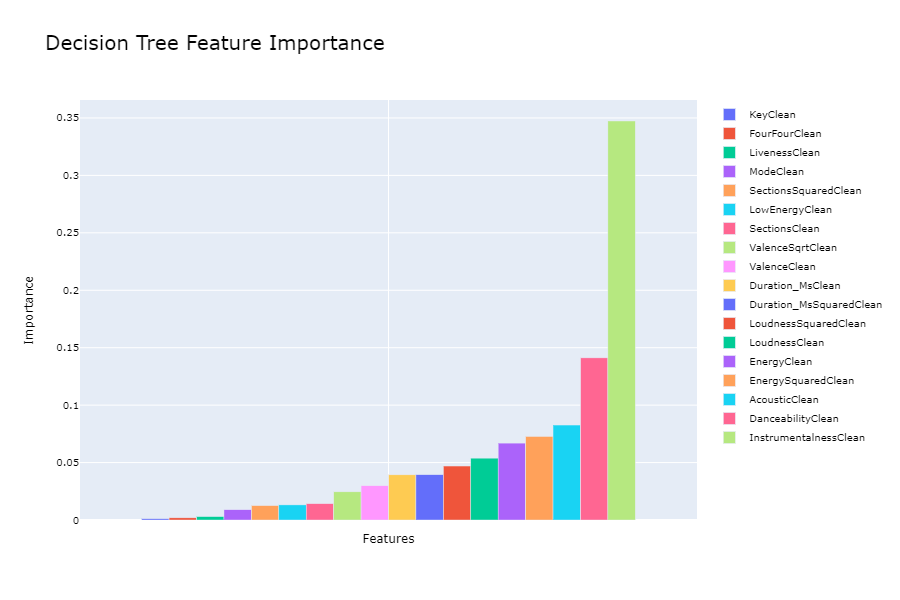

In [69]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

## Model Comparison

In [83]:
Comparison = pd.DataFrame()
Models = ["LogisticRegression", "DecisionTree", "RandomForest"]

Comparison["ScoreTrain"] = [Scores[str(Model)+"Train"] for Model in Models]
Comparison["ScoreTest"] = [Scores[str(Model)+"Test"] for Model in Models]

Comparison["PrecisionsTrain"] = [Precisions[str(Model)+"Train"] for Model in Models]
Comparison["PrecisionsTest"] = [Precisions[str(Model)+"Test"] for Model in Models]

Comparison["RecallsTrain"] = [Recalls[str(Model)+"Train"] for Model in Models]
Comparison["RecallsTest"] = [Recalls[str(Model)+"Test"] for Model in Models]

Comparison["AucsTrain"] = [Aucs[str(Model)+"Train"] for Model in Models]
Comparison["AucsTest"] = [Aucs[str(Model)+"Test"] for Model in Models]

Comparison.index = Models

In [86]:
Comparison

ScoreTrain  ScoreTest  PrecisionsTrain  PrecisionsTest  \
LogisticRegression    0.751586   0.747163         0.809089        0.815027   
DecisionTree          0.605658   0.590208         0.833021        0.809286   
RandomForest          0.768421   0.759276         0.847767        0.846730   

                    RecallsTrain  RecallsTest  AucsTrain  AucsTest  
LogisticRegression      0.723989     0.724429   0.755062  0.751153  
DecisionTree            0.571050     0.569571   0.634128  0.607194  
RandomForest            0.730169     0.726961   0.775447  0.766848